<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/17_Ultra_Light_RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Используя шаблон ноутбука, напишите четыре нейронки для распознавания писателей. Для этого выполните следующее:

1. Загрузите данные и разделите на слова.
2. Создайте словарь и превратите данные в индексы.
3. Превратите данные в обучающую выборку.
4. Напишите нейронные сети.

Четыре нейронки, которые нужно написать:
1. Embedding + Dense сеть.
2. Embedding + LSTM сеть.
3. Embedding + Conv1D сеть.
4. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Для выполнения задания можно смотреть в ноутбук задания, но код желательно писать своими руками, а не копировать.

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
# Чтение файла + запись в одну строку
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text


# Функции для формирования выборки по отрезкам текста с заданным шагом
# Разделение на короткие векторы
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  #Идем по всей длине вектора индексов и откусываем векторы длиной xLen , смещаемся на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

# Формирование обучающей и проверочной выборки из двух листов индексов от двух классов

def createSetsMultiClasses (wordIndexes, xLen, step):
  #Для каждого из 6 классов создаем обучающую и проверочную выборки из индексов
  nClasses = len(wordIndexes) #задали количество классов выборки
  classesXSamples = [] # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  #Создаем один общий xSamples
  xSamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range (nClasses):   # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]    # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range (len(xT)):  # и каждое его окно
      xSamples.append(xT[i])   # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса  
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):   # на каждое окно выборки 
      ySamples.append(currY)   # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples) # функция возвращает выборку и соответствующие векторы классов

# Представляем тестовую выборку в удобных для распознавания размерах
 
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
   
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
     
   
  return  xTest6Classes # функция вернёт тестовые данные: xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты

def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим средний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount




In [ ]:
# График 

def show_res():
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  # Строим график для отображения динамики обучения и точности предсказания сети
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

# Загрузка данных


In [ ]:
# Cоздание обучающей выборки
trainText = []
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt'))
trainText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))

className = ['О. Генри', 'Стругацкие', 'Булгаков', 'Саймак', 'Фрай', 'Брэдберри']
nClasses = len(className)

# Создание тестовой выборки
testText = []
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))
testText.append(readText('/content/drive/MyDrive/Colab Notebooks/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))

# Обработка данных


In [ ]:
# Преобразуем данные в числовые/векторные
maxWordsCount = 20000

tokenizer = Tokenizer(num_words=maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', char_level = False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова
tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:20]) # взглянем на содержимое словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20)]


In [ ]:
# Преобразовываем  текст в последовательность индексов согласно словарю частотности
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

# Создание обучающей и проверочной выборки

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


# Эксперименты

## Embedding + Dense

####**Иссл. №1**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 5)           20        
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 64)          384       
_________________________________________________________________
dense_12 (Dense)             (None, 1000, 32)          2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                

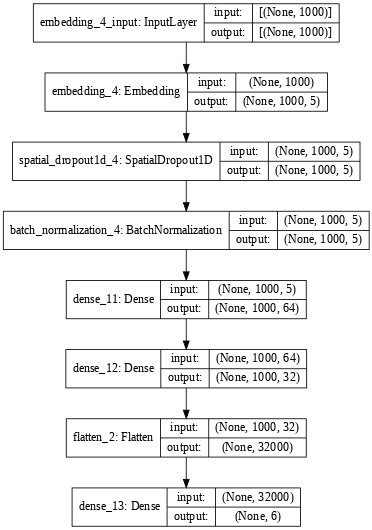

In [ ]:
modelEmb_Dense = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEmb_Dense.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelEmb_Dense.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEmb_Dense.add(BatchNormalization()) # добавляем слой нормализации данных

modelEmb_Dense.add(Dense(64, activation = 'relu')) 

modelEmb_Dense.add(Dense(32, activation='relu')) 
modelEmb_Dense.add(Flatten())
modelEmb_Dense.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEmb_Dense.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelEmb_Dense.summary() # Выводим summary модели
print()
plot_model(modelEmb_Dense, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEmb_Dense.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 4s 74ms/step - loss: 1.8236 - accuracy: 0.3096 - val_loss: 1.7934 - val_accuracy: 0.1974
Epoch 2/50
35/35 [==============================] - 2s 54ms/step - loss: 0.9563 - accuracy: 0.6517 - val_loss: 1.8529 - val_accuracy: 0.1969
Epoch 3/50
35/35 [==============================] - 2s 54ms/step - loss: 0.3030 - accuracy: 0.9229 - val_loss: 1.8609 - val_accuracy: 0.0793
Epoch 4/50
35/35 [==============================] - 2s 54ms/step - loss: 0.1018 - accuracy: 0.9749 - val_loss: 1.8460 - val_accuracy: 0.1307
Epoch 5/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0796 - accuracy: 0.9739 - val_loss: 1.7773 - val_accuracy: 0.1785
Epoch 6/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0273 - accuracy: 0.9940 - val_loss: 1.8781 - val_accuracy: 0.1310
Epoch 7/50
35/35 [==============================] - 2s 55ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 1.5845 - val_accuracy: 0.3175
Epoch 8/50
35

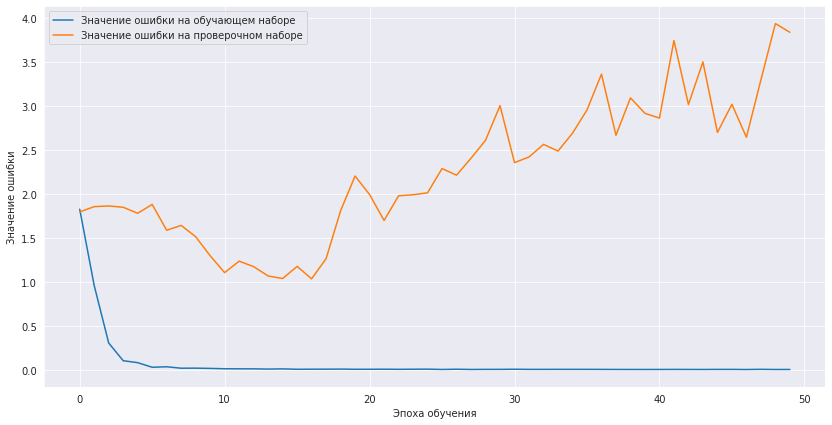

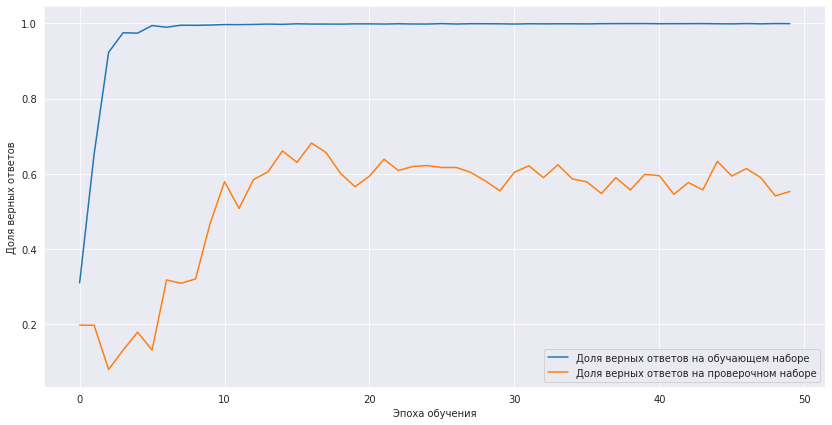

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

pred = recognizeMultiClass(modelEmb_Dense, xTest6Classes, "Embedding + Dense") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Dense

О. Генри  распознано  13 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  70 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  78 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  8 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Фрай  распознано  44 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  67 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  51 %



####**Иссл. №2**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 80)          1600000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 80)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1000, 80)          320       
_________________________________________________________________
dense_8 (Dense)              (None, 1000, 64)          5184      
_________________________________________________________________
dense_9 (Dense)              (None, 1000, 32)          2080      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                

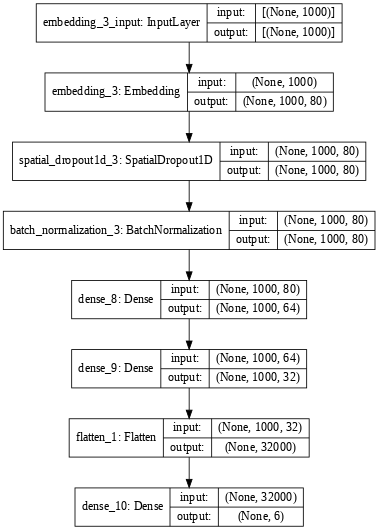

In [ ]:
# Embedding = 80
modelEmb_Dense2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEmb_Dense2.add(Embedding(maxWordsCount, 80, input_length=xLen))

modelEmb_Dense2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEmb_Dense2.add(BatchNormalization()) # добавляем слой нормализации данных

modelEmb_Dense2.add(Dense(64, activation = 'relu')) 

modelEmb_Dense2.add(Dense(32, activation='relu')) 
modelEmb_Dense2.add(Flatten())
modelEmb_Dense2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEmb_Dense2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelEmb_Dense2.summary() # Выводим summary модели
print()
plot_model(modelEmb_Dense2, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEmb_Dense2.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 5s 125ms/step - loss: 3.3876 - accuracy: 0.2565 - val_loss: 1.7917 - val_accuracy: 0.1611
Epoch 2/50
35/35 [==============================] - 4s 117ms/step - loss: 0.9999 - accuracy: 0.6256 - val_loss: 1.7752 - val_accuracy: 0.1116
Epoch 3/50
35/35 [==============================] - 4s 116ms/step - loss: 0.1590 - accuracy: 0.9618 - val_loss: 1.7447 - val_accuracy: 0.1303
Epoch 4/50
35/35 [==============================] - 4s 116ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.6747 - val_accuracy: 0.2385
Epoch 5/50
35/35 [==============================] - 4s 117ms/step - loss: 0.1013 - accuracy: 0.9770 - val_loss: 1.6184 - val_accuracy: 0.3211
Epoch 6/50
35/35 [==============================] - 4s 116ms/step - loss: 6.9213e-04 - accuracy: 1.0000 - val_loss: 1.5319 - val_accuracy: 0.3886
Epoch 7/50
35/35 [==============================] - 4s 117ms/step - loss: 2.4877e-04 - accuracy: 1.0000 - val_loss: 1.4113 - val_accuracy: 0.480

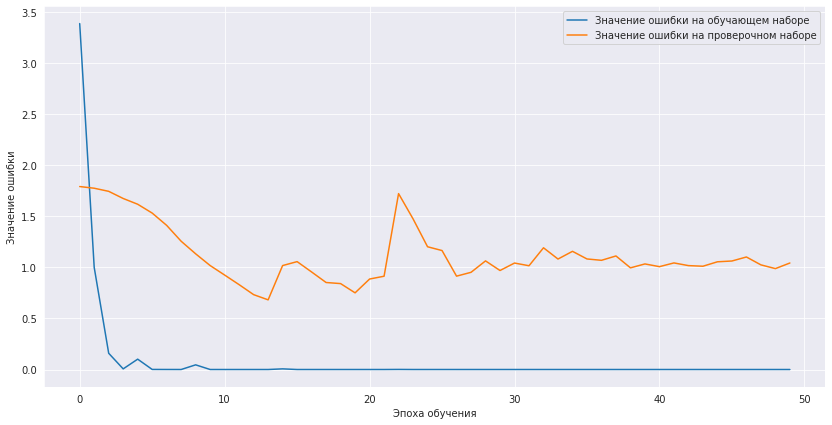

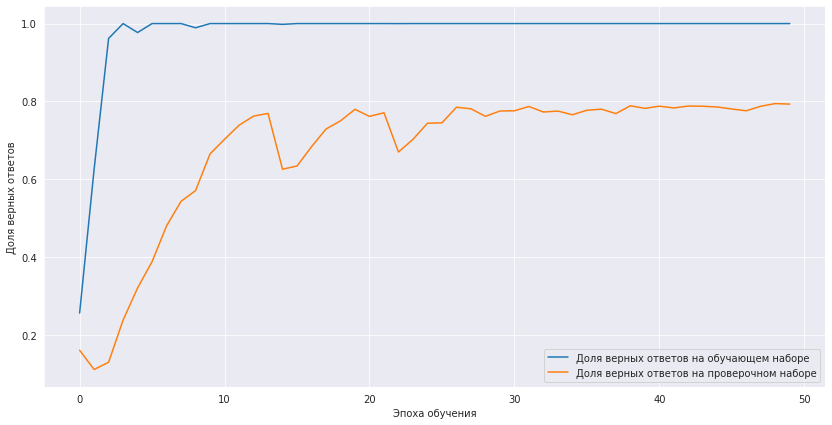

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(modelEmb_Dense2, xTest6Classes, "modelEmb_Dense2") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  modelEmb_Dense2

О. Генри  распознано  57 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  90 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  91 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  88 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  90 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  60 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  79 %



####**Иссл. №3**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 80)          1600000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1000, 80)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 80)          320       
_________________________________________________________________
dense_17 (Dense)             (None, 1000, 64)          5184      
_________________________________________________________________
dense_18 (Dense)             (None, 1000, 32)          2080      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                

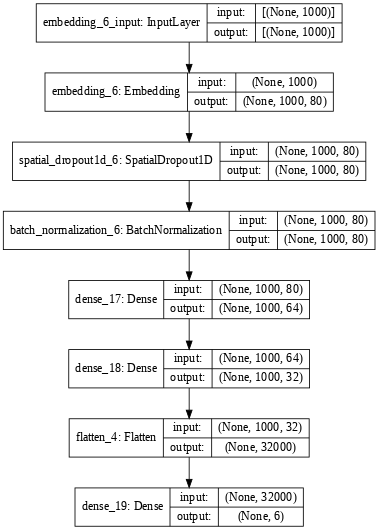

In [ ]:
# SpatialDropout1D(0.4)
modelEmb_Dense3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEmb_Dense3.add(Embedding(maxWordsCount, 80, input_length=xLen))

modelEmb_Dense3.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEmb_Dense3.add(BatchNormalization()) # добавляем слой нормализации данных

modelEmb_Dense3.add(Dense(64, activation = 'relu')) 

modelEmb_Dense3.add(Dense(32, activation='relu')) 
modelEmb_Dense3.add(Flatten())
modelEmb_Dense3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEmb_Dense3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelEmb_Dense3.summary() # Выводим summary модели
print()
plot_model(modelEmb_Dense3, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelEmb_Dense3.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 4s 120ms/step - loss: 1.4042e-09 - accuracy: 1.0000 - val_loss: 1.2032 - val_accuracy: 0.7393
Epoch 2/50
35/35 [==============================] - 4s 117ms/step - loss: 1.9780e-09 - accuracy: 1.0000 - val_loss: 1.0953 - val_accuracy: 0.7551
Epoch 3/50
35/35 [==============================] - 4s 117ms/step - loss: 6.0759e-10 - accuracy: 1.0000 - val_loss: 1.1056 - val_accuracy: 0.7535
Epoch 4/50
35/35 [==============================] - 4s 117ms/step - loss: 8.3037e-10 - accuracy: 1.0000 - val_loss: 1.0985 - val_accuracy: 0.7545
Epoch 5/50
35/35 [==============================] - 4s 117ms/step - loss: 9.0463e-10 - accuracy: 1.0000 - val_loss: 1.1164 - val_accuracy: 0.7542
Epoch 6/50
35/35 [==============================] - 4s 116ms/step - loss: 6.9535e-10 - accuracy: 1.0000 - val_loss: 1.0555 - val_accuracy: 0.7644
Epoch 7/50
35/35 [==============================] - 4s 117ms/step - loss: 7.1561e-10 - accuracy: 1.0000 - val_loss: 1.0522 -

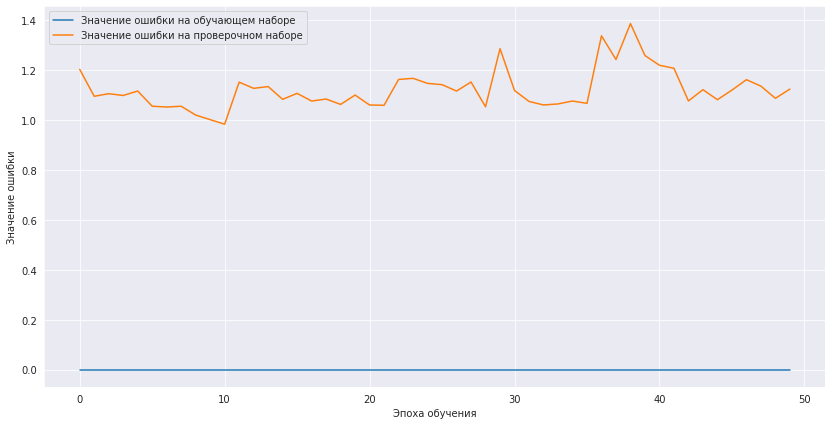

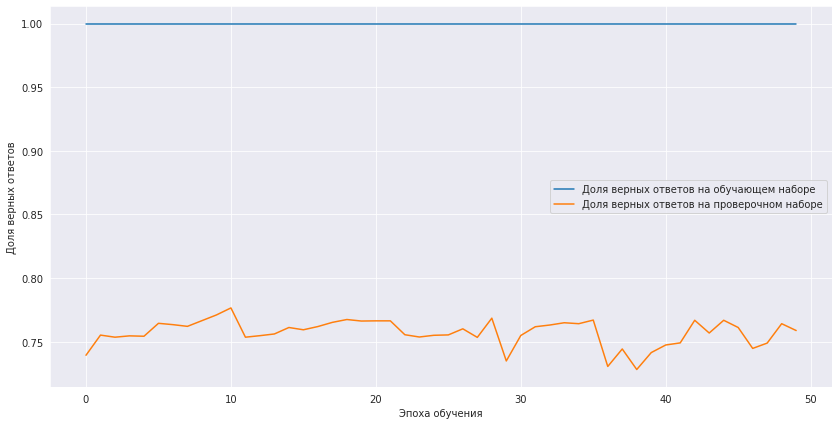

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(modelEmb_Dense3 , xTest6Classes, "modelEmb_Dense3") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  modelEmb_Dense3

О. Генри  распознано  52 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  48 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  84 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  90 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  92 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  73 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  75 %



## Embedding + LSTM  

####**Иссл. №4**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 30        
Total params: 100,210
Trainable params: 100,200
Non-trainable params: 10
_________________________________________________________________



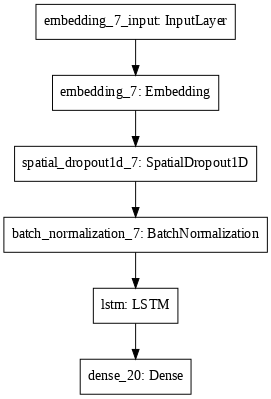

In [ ]:
model_Emb_LSTM_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_LSTM_1.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_Emb_LSTM_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_LSTM_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_LSTM_1.add(LSTM(4))
model_Emb_LSTM_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_LSTM_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_LSTM_1.summary()
print()
plot_model(model_Emb_LSTM_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_LSTM_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 11s 176ms/step - loss: 1.7384 - accuracy: 0.3192 - val_loss: 1.7620 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 6s 159ms/step - loss: 1.6691 - accuracy: 0.3626 - val_loss: 1.7521 - val_accuracy: 0.2928
Epoch 3/100
35/35 [==============================] - 6s 159ms/step - loss: 1.5824 - accuracy: 0.4098 - val_loss: 1.8106 - val_accuracy: 0.1652
Epoch 4/100
35/35 [==============================] - 6s 160ms/step - loss: 1.4672 - accuracy: 0.4657 - val_loss: 1.8434 - val_accuracy: 0.1611
Epoch 5/100
35/35 [==============================] - 6s 158ms/step - loss: 1.3872 - accuracy: 0.4790 - val_loss: 1.8627 - val_accuracy: 0.1611
Epoch 6/100
35/35 [==============================] - 6s 159ms/step - loss: 1.3436 - accuracy: 0.4786 - val_loss: 1.8801 - val_accuracy: 0.1614
Epoch 7/100
35/35 [==============================] - 6s 159ms/step - loss: 1.3224 - accuracy: 0.4791 - val_loss: 1.8971 - val_accuracy: 0.161

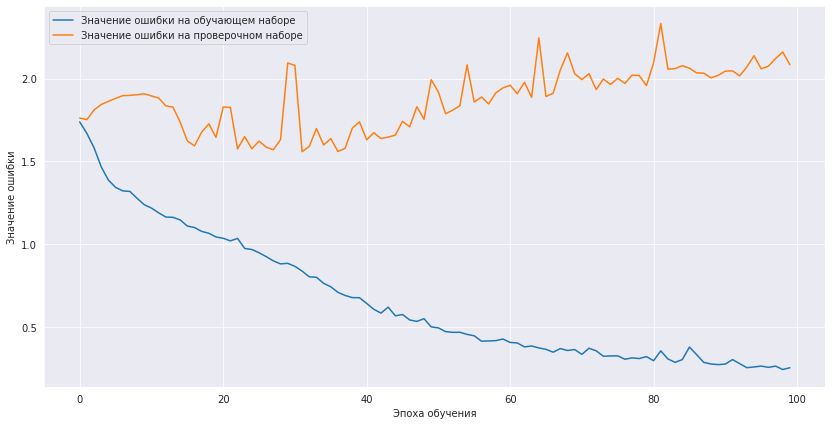

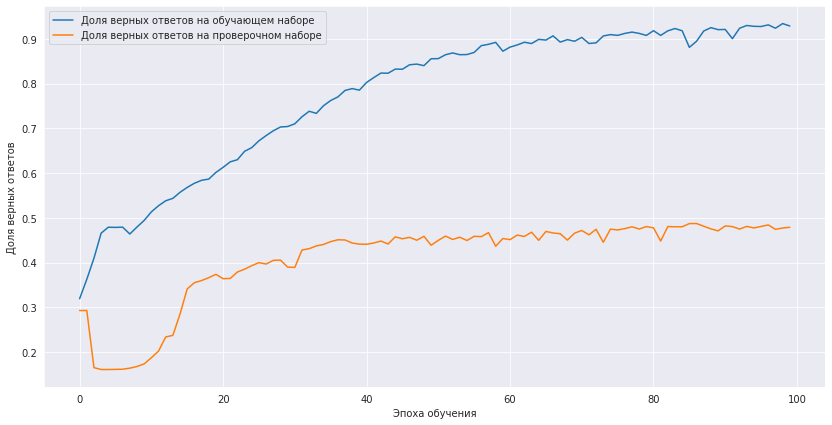

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_LSTM_1, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  43 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  38 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  65 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  31 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  45 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  34 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  47 %



####**Иссл. №5**

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1000, 5)           20        
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 160       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 30        
Total params: 100,210
Trainable params: 100,200
Non-trainable params: 10
_________________________________________________________________



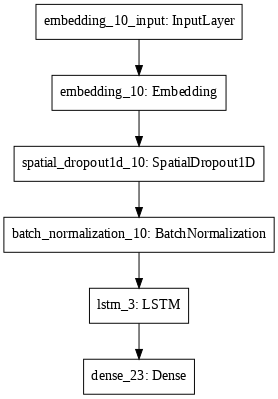

In [ ]:
# Embedding = 80

model_Emb_LSTM_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_LSTM_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_Emb_LSTM_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_LSTM_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_LSTM_2.add(LSTM(4))
model_Emb_LSTM_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_LSTM_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_LSTM_2.summary()
print()
plot_model(model_Emb_LSTM_2 , dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_LSTM_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 8s 175ms/step - loss: 1.7686 - accuracy: 0.2591 - val_loss: 1.7667 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 5s 156ms/step - loss: 1.7016 - accuracy: 0.3347 - val_loss: 1.7443 - val_accuracy: 0.2928
Epoch 3/100
35/35 [==============================] - 5s 152ms/step - loss: 1.6446 - accuracy: 0.3477 - val_loss: 1.7335 - val_accuracy: 0.2928
Epoch 4/100
35/35 [==============================] - 5s 152ms/step - loss: 1.5932 - accuracy: 0.3693 - val_loss: 1.7315 - val_accuracy: 0.2928
Epoch 5/100
35/35 [==============================] - 5s 153ms/step - loss: 1.5341 - accuracy: 0.3996 - val_loss: 1.7255 - val_accuracy: 0.2928
Epoch 6/100
35/35 [==============================] - 5s 152ms/step - loss: 1.4662 - accuracy: 0.4299 - val_loss: 1.7791 - val_accuracy: 0.2925
Epoch 7/100
35/35 [==============================] - 5s 151ms/step - loss: 1.3791 - accuracy: 0.4720 - val_loss: 1.6143 - val_accuracy: 0.2993

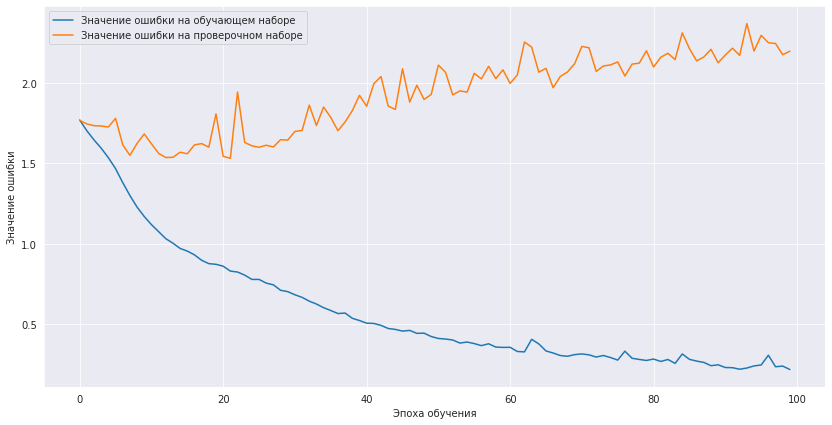

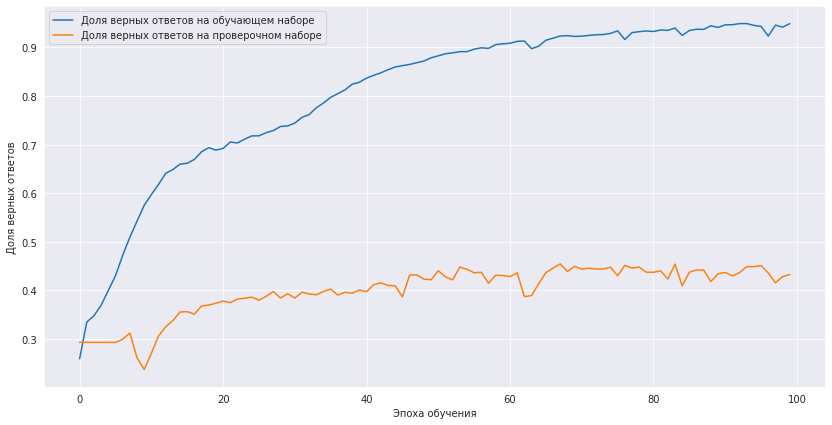

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_LSTM_2, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  19 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  26 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Булгаков  распознано  71 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  34 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Фрай  распознано  41 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  35 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  43 %



####**Иссл. №6**

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1000, 5)           20        
_________________________________________________________________
lstm_4 (LSTM)                (None, 80)                27520     
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 486       
Total params: 128,026
Trainable params: 128,016
Non-trainable params: 10
_________________________________________________________________



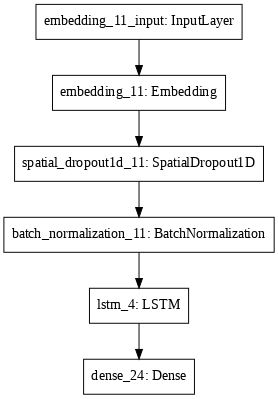

In [ ]:
# LSTM(80)

model_Emb_LSTM_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_LSTM_3.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_Emb_LSTM_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_LSTM_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_LSTM_3.add(LSTM(80))
model_Emb_LSTM_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_LSTM_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_LSTM_3.summary()
print()
plot_model(model_Emb_LSTM_3 , dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_LSTM_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 13s 301ms/step - loss: 1.5317 - accuracy: 0.3870 - val_loss: 2.0329 - val_accuracy: 0.1972
Epoch 2/100
35/35 [==============================] - 10s 285ms/step - loss: 1.4825 - accuracy: 0.3960 - val_loss: 1.8945 - val_accuracy: 0.1972
Epoch 3/100
35/35 [==============================] - 10s 284ms/step - loss: 1.2464 - accuracy: 0.4750 - val_loss: 1.9680 - val_accuracy: 0.1617
Epoch 4/100
35/35 [==============================] - 10s 285ms/step - loss: 1.1851 - accuracy: 0.5068 - val_loss: 1.9810 - val_accuracy: 0.2278
Epoch 5/100
35/35 [==============================] - 10s 284ms/step - loss: 1.0764 - accuracy: 0.5548 - val_loss: 1.6755 - val_accuracy: 0.3139
Epoch 6/100
35/35 [==============================] - 10s 284ms/step - loss: 1.1604 - accuracy: 0.5553 - val_loss: 1.8050 - val_accuracy: 0.0740
Epoch 7/100
35/35 [==============================] - 10s 285ms/step - loss: 1.0687 - accuracy: 0.5891 - val_loss: 1.7936 - val_accuracy:

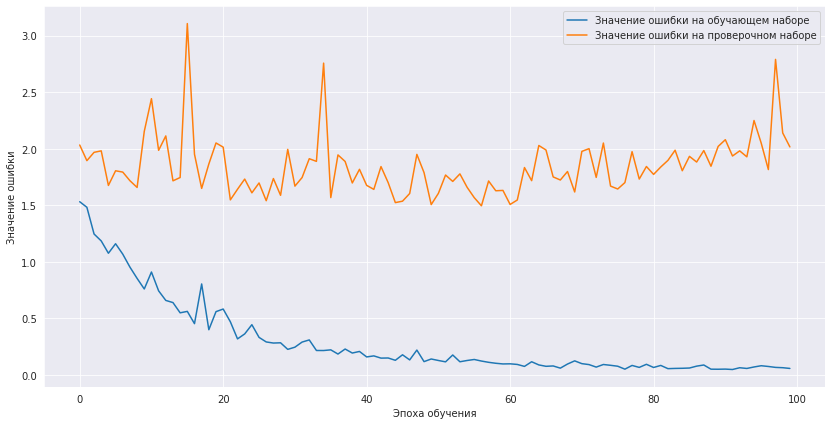

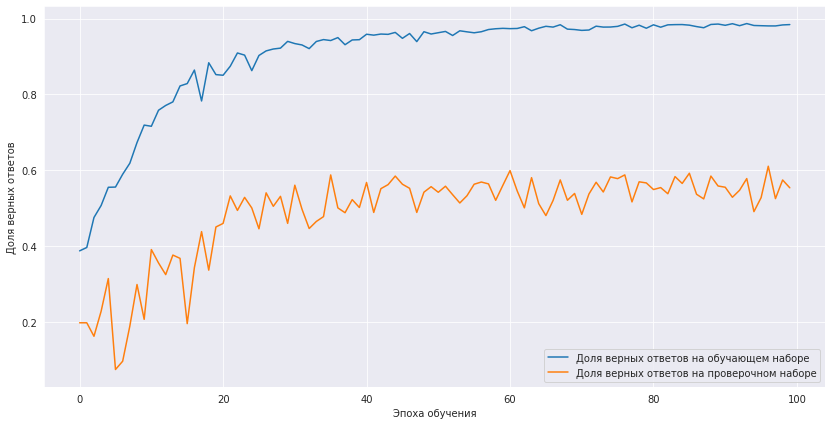

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_LSTM_3, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  23 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  69 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  80 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  37 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  45 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  62 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  55 %



##Embedding + Conv1D 


####**Иссл. №7**

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1000, 10)          40        
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 20)          1020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 20)           2020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 498, 20)           0         
_________________________________________________________________
dropout (Dropout)            (None, 498, 20)         

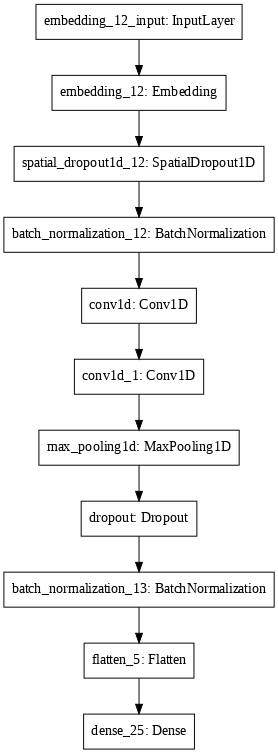

In [ ]:
model_Emb_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Conv_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Emb_Conv_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Emb_Conv_1.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Conv_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Conv_1.summary()
print()
plot_model(model_Emb_Conv_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 30s 36ms/step - loss: 1.2247 - accuracy: 0.5643 - val_loss: 4.2152 - val_accuracy: 0.1611
Epoch 2/100
89/89 [==============================] - 3s 31ms/step - loss: 0.0776 - accuracy: 0.9767 - val_loss: 6.3102 - val_accuracy: 0.2373
Epoch 3/100
89/89 [==============================] - 3s 31ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 7.5949 - val_accuracy: 0.2086
Epoch 4/100
89/89 [==============================] - 3s 31ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 6.8704 - val_accuracy: 0.1621
Epoch 5/100
89/89 [==============================] - 3s 31ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 4.5943 - val_accuracy: 0.4018
Epoch 6/100
89/89 [==============================] - 3s 32ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 2.9828 - val_accuracy: 0.4842
Epoch 7/100
89/89 [==============================] - 3s 31ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 2.8723 - val_accuracy: 0.4738
Epoch

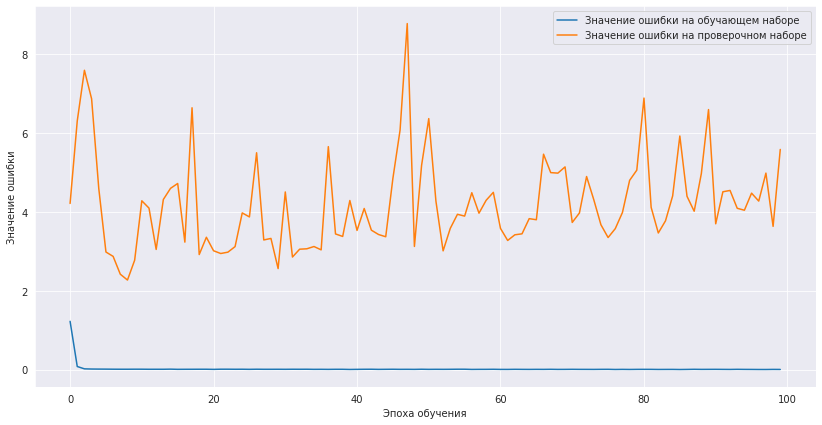

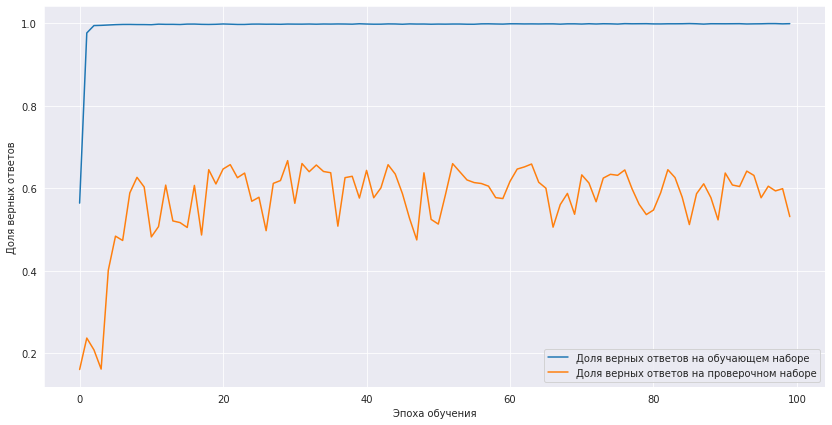

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_Conv_1, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  36 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  68 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  79 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  88 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  8 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Брэдберри  распознано  55 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  53 %



####**Иссл. №8**

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 20)          5020      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 20)           2020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 498, 20)         

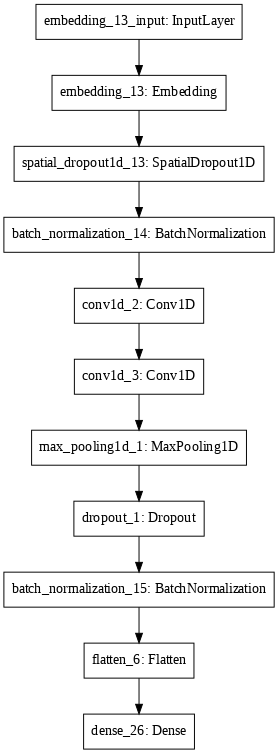

In [ ]:
# Embedding = 50
model_Emb_Conv_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Conv_2.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Emb_Conv_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Conv_2.add(BatchNormalization())  # добавляем слой нормализации данных
model_Emb_Conv_2.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Conv_2.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Conv_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Conv_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Conv_2.summary()
print()
plot_model(model_Emb_Conv_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Conv_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 7s 60ms/step - loss: 0.8928 - accuracy: 0.6891 - val_loss: 5.0559 - val_accuracy: 0.0781
Epoch 2/100
89/89 [==============================] - 5s 55ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 8.9909 - val_accuracy: 0.0781
Epoch 3/100
89/89 [==============================] - 5s 55ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 2.1932 - val_accuracy: 0.4482
Epoch 4/100
89/89 [==============================] - 5s 55ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 3.0592 - val_accuracy: 0.4052
Epoch 5/100
89/89 [==============================] - 5s 54ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 2.0356 - val_accuracy: 0.4439
Epoch 6/100
89/89 [==============================] - 5s 56ms/step - loss: 6.1846e-04 - accuracy: 0.9997 - val_loss: 4.0070 - val_accuracy: 0.3889
Epoch 7/100
89/89 [==============================] - 5s 55ms/step - loss: 4.2807e-04 - accuracy: 0.9998 - val_loss: 2.0659 - val_accuracy: 0.571

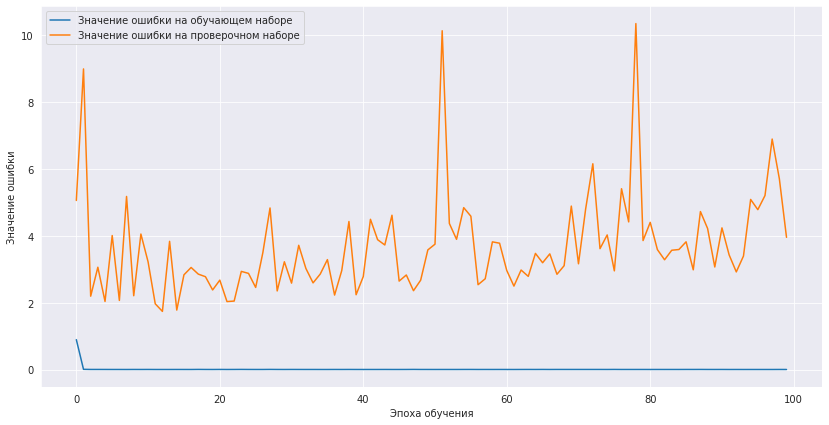

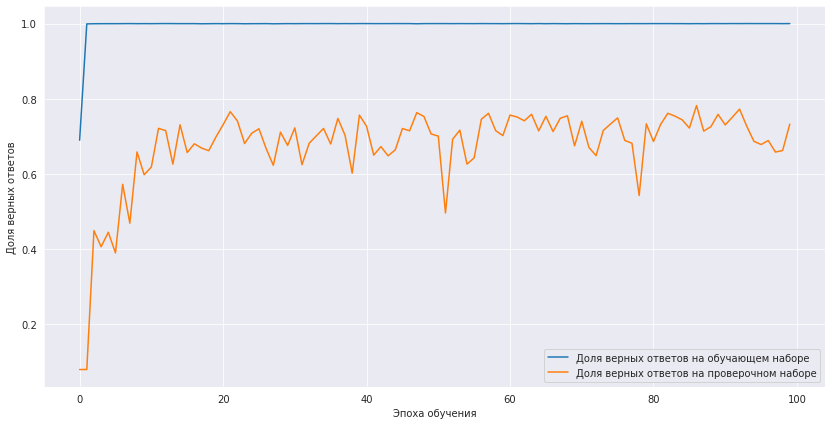

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_Conv_2, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  60 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  56 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  79 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  84 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  77 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  73 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  73 %



####**Иссл. №9**

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1000, 20)          5020      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 20)           2020      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 498, 20)         

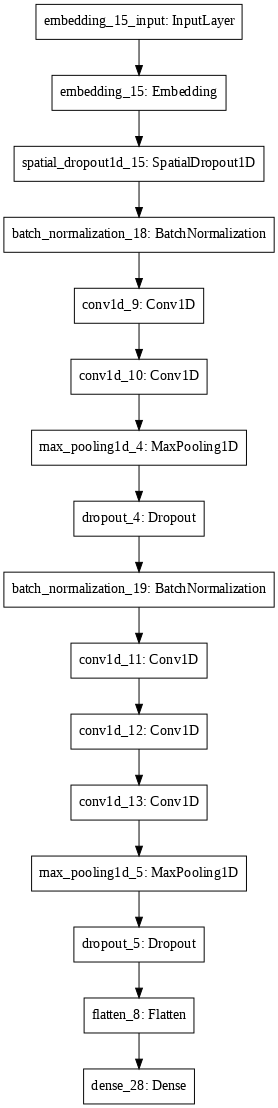

In [ ]:
# Добавм слоев Conv1D
model_Emb_Conv_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Conv_3.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Emb_Conv_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Conv_3.add(BatchNormalization())  # добавляем слой нормализации данных
model_Emb_Conv_3.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Conv_3.add(Conv1D(20, 5, activation="relu"))
model_Emb_Conv_3.add(Conv1D(20, 5, activation="relu"))
model_Emb_Conv_3.add(Conv1D(20, 5, activation="relu"))
model_Emb_Conv_3.add(MaxPooling1D(2)) 
model_Emb_Conv_3.add(Dropout(0.2))
model_Emb_Conv_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Conv_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Conv_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Conv_3.summary()
print()
plot_model(model_Emb_Conv_3, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Conv_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 9s 77ms/step - loss: 1.4476 - accuracy: 0.4221 - val_loss: 3.2427 - val_accuracy: 0.1972
Epoch 2/100
89/89 [==============================] - 6s 72ms/step - loss: 0.3454 - accuracy: 0.8590 - val_loss: 7.2735 - val_accuracy: 0.0781
Epoch 3/100
89/89 [==============================] - 6s 72ms/step - loss: 0.0418 - accuracy: 0.9863 - val_loss: 14.3903 - val_accuracy: 0.0781
Epoch 4/100
89/89 [==============================] - 6s 72ms/step - loss: 0.0160 - accuracy: 0.9948 - val_loss: 17.9225 - val_accuracy: 0.0781
Epoch 5/100
89/89 [==============================] - 6s 72ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 15.7391 - val_accuracy: 0.0781
Epoch 6/100
89/89 [==============================] - 6s 72ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 9.1760 - val_accuracy: 0.1403
Epoch 7/100
89/89 [==============================] - 6s 72ms/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 8.8794 - val_accuracy: 0.2298
Epo

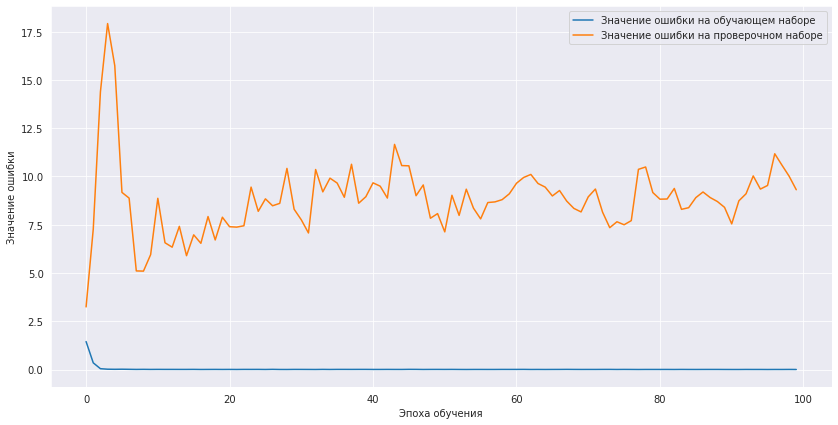

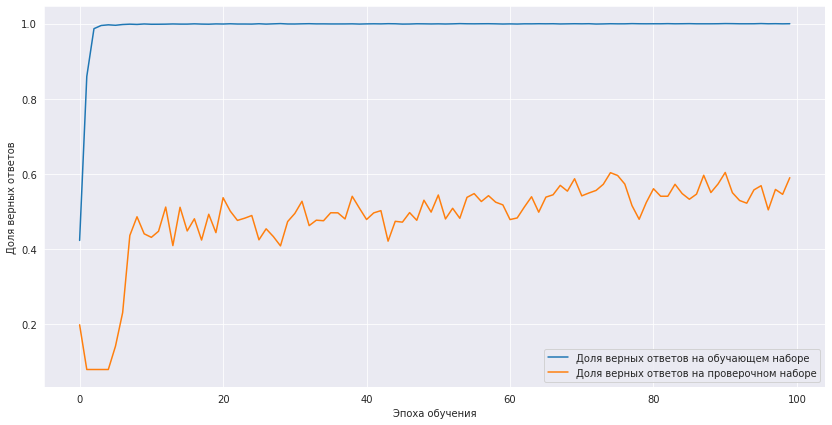

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
pred = recognizeMultiClass(model_Emb_Conv_3, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  70 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  30 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Булгаков  распознано  77 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  14 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Фрай  распознано  66 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  35 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  58 %



##Embedding + сложная сеть из Dense, LSTM и Conv1D

####**Иссл. №10**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 10)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 4)           240       
_________________________________________________________________
dense (Dense)                (None, 1000, 100)         500       
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 20)           10020     
_________________________________________________________________
lstm_1 (LSTM)                (None, 996, 4)            400       
_________________________________________________________________
dropout (Dropout)            (None, 996, 4)            0

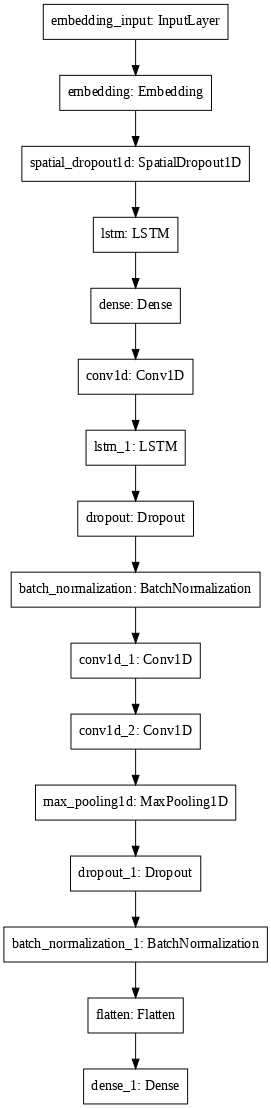

In [ ]:
# 2 слоя LSTM
model_Emb_Dense_LSTM_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Dense_LSTM_Conv_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Emb_Dense_LSTM_Conv_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_Emb_Dense_LSTM_Conv_1.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Emb_Dense_LSTM_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_Emb_Dense_LSTM_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Dense_LSTM_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Dense_LSTM_Conv_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Dense_LSTM_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Dense_LSTM_Conv_1.summary()
print()
plot_model(model_Emb_Dense_LSTM_Conv_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Dense_LSTM_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 34s 139ms/step - loss: 0.8348 - accuracy: 0.6650 - val_loss: 3.7998 - val_accuracy: 0.1649
Epoch 2/100
89/89 [==============================] - 11s 127ms/step - loss: 0.0999 - accuracy: 0.9664 - val_loss: 5.1568 - val_accuracy: 0.0738
Epoch 3/100
89/89 [==============================] - 11s 128ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 6.3208 - val_accuracy: 0.2710
Epoch 4/100
89/89 [==============================] - 11s 127ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 7.8963 - val_accuracy: 0.2897
Epoch 5/100
89/89 [==============================] - 11s 127ms/step - loss: 0.0139 - accuracy: 0.9954 - val_loss: 4.8732 - val_accuracy: 0.2948
Epoch 6/100
89/89 [==============================] - 11s 127ms/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 4.2724 - val_accuracy: 0.3408
Epoch 7/100
89/89 [==============================] - 11s 128ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 5.0964 - val_accuracy:

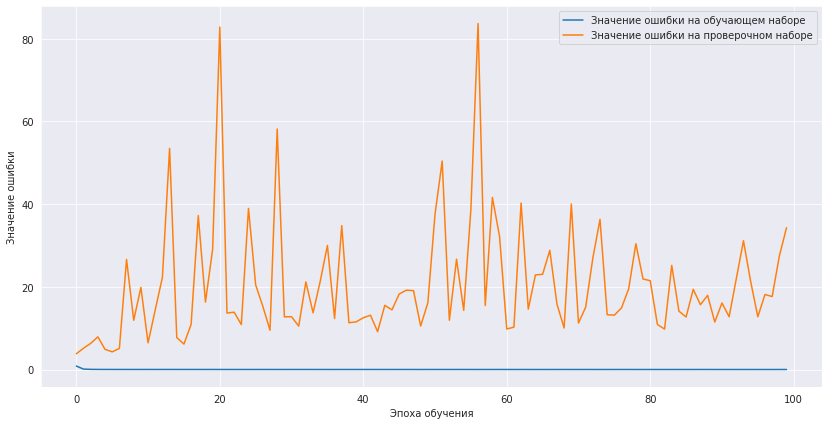

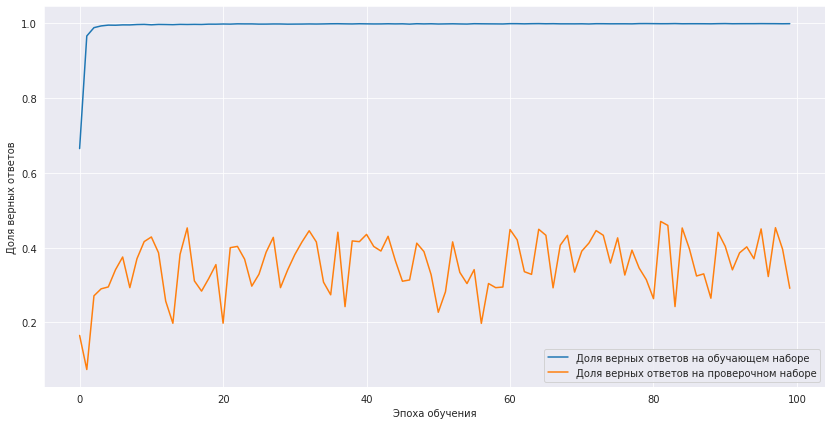

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

In [ ]:
xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass
pred = recognizeMultiClass(model_Emb_Dense_LSTM_Conv_1, xTest6Classes, "Embedding + Dense + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

О. Генри  распознано  99 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  1 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Булгаков  распознано  31 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Саймак  распознано  0 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  0 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Брэдберри  распознано  0 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  29 %



####**Иссл. №11**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 4)           880       
_________________________________________________________________
dense_3 (Dense)              (None, 1000, 100)         500       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
lstm_4 (LSTM)                (None, 996, 4)            400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 996, 4)           

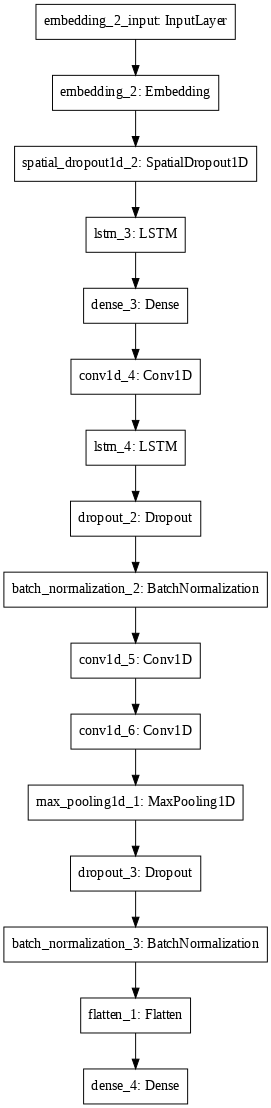

In [ ]:
# Embedding = 50
model_Emb_Dense_LSTM_Conv_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Dense_LSTM_Conv_2.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Emb_Dense_LSTM_Conv_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_Emb_Dense_LSTM_Conv_2.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Emb_Dense_LSTM_Conv_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_2.add(LSTM(4, return_sequences=1 )) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_Emb_Dense_LSTM_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Dense_LSTM_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_2.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Dense_LSTM_Conv_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Dense_LSTM_Conv_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Dense_LSTM_Conv_2.summary()
print()
plot_model(model_Emb_Dense_LSTM_Conv_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Dense_LSTM_Conv_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 17s 140ms/step - loss: 0.5391 - accuracy: 0.7836 - val_loss: 2.1232 - val_accuracy: 0.1969
Epoch 2/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0277 - accuracy: 0.9917 - val_loss: 4.3903 - val_accuracy: 0.1969
Epoch 3/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 9.5917 - val_accuracy: 0.2205
Epoch 4/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 11.7145 - val_accuracy: 0.2146
Epoch 5/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 11.3763 - val_accuracy: 0.3468
Epoch 6/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 6.8945 - val_accuracy: 0.4527
Epoch 7/100
89/89 [==============================] - 12s 130ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 13.9924 - val_accura

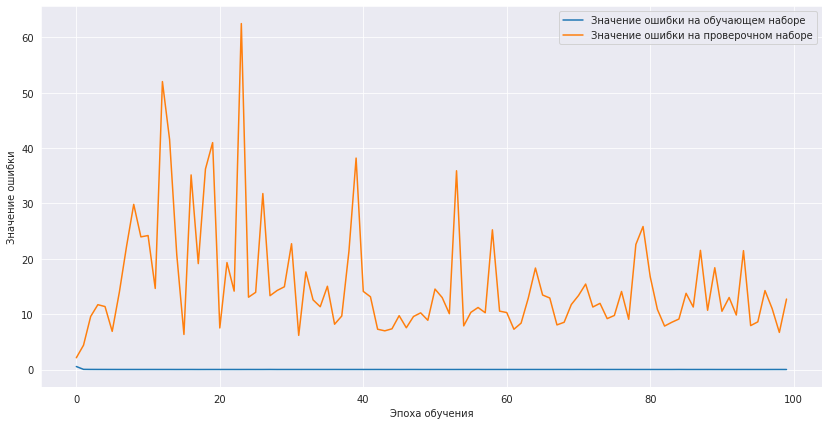

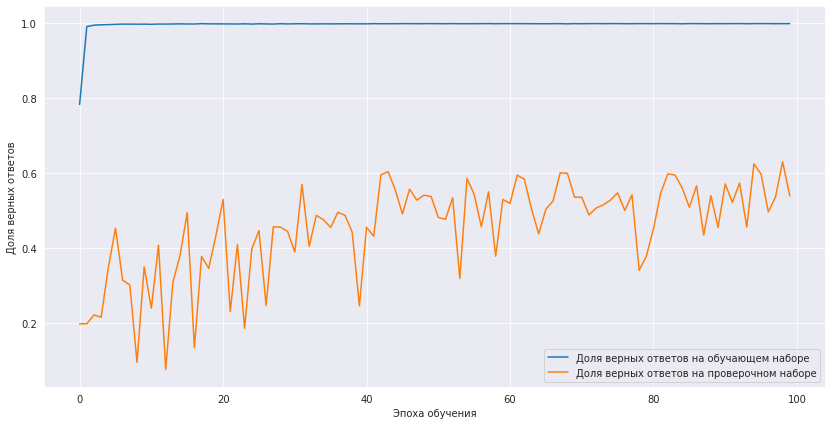

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()


In [ ]:
pred = recognizeMultiClass(model_Emb_Dense_LSTM_Conv_2, xTest6Classes, "Embedding + Dense + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Dense + Conv + LSTM

О. Генри  распознано  6 % сеть считает, что это  Брэдберри ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  89 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  85 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  17 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  35 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдберри  распознано  79 % сеть считает, что это  Брэдберри ,  распознано ВЕРНО!

Средний процент распознавания  53 %



####**Иссл. №12**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 50)          20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1000, 100)         5100      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 996, 20)           10020     
_________________________________________________________________
dropout_4 (Dropout)          (None, 996, 20)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 996, 20)          

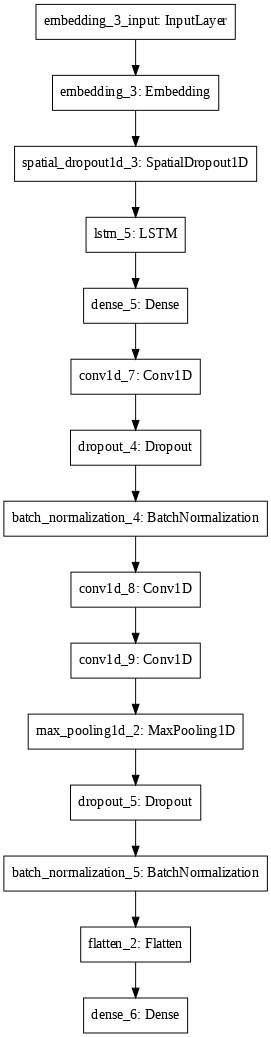

In [ ]:
# LSTM = 50
model_Emb_Dense_LSTM_Conv_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_Dense_LSTM_Conv_3.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Emb_Dense_LSTM_Conv_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_3.add(LSTM(50, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_Emb_Dense_LSTM_Conv_3.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Emb_Dense_LSTM_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
# model_Emb_Dense_LSTM_Conv_2.add(LSTM(4, return_sequences=1 ))  
model_Emb_Dense_LSTM_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Emb_Dense_LSTM_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Emb_Dense_LSTM_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Emb_Dense_LSTM_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_Dense_LSTM_Conv_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Emb_Dense_LSTM_Conv_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_Dense_LSTM_Conv_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Emb_Dense_LSTM_Conv_3.summary()
print()
plot_model(model_Emb_Dense_LSTM_Conv_3, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_Dense_LSTM_Conv_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 12s 100ms/step - loss: 0.7031 - accuracy: 0.7337 - val_loss: 2.0075 - val_accuracy: 0.0738
Epoch 2/100
89/89 [==============================] - 8s 90ms/step - loss: 0.0465 - accuracy: 0.9890 - val_loss: 5.2883 - val_accuracy: 0.0781
Epoch 3/100
89/89 [==============================] - 8s 90ms/step - loss: 0.0172 - accuracy: 0.9945 - val_loss: 10.3524 - val_accuracy: 0.0781
Epoch 4/100
89/89 [==============================] - 8s 90ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 12.2603 - val_accuracy: 0.0781
Epoch 5/100
89/89 [==============================] - 8s 89ms/step - loss: 0.0069 - accuracy: 0.9975 - val_loss: 16.7552 - val_accuracy: 0.1618
Epoch 6/100
89/89 [==============================] - 8s 89ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 16.0149 - val_accuracy: 0.3002
Epoch 7/100
89/89 [==============================] - 8s 89ms/step - loss: 0.0089 - accuracy: 0.9967 - val_loss: 12.1892 - val_accuracy: 0.4149

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()


In [ ]:
pred = recognizeMultiClass(model_Emb_Dense_LSTM_Conv_3, xTest6Classes, "Embedding + Dense + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

О. Генри  распознано  18 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  61 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  44 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  45 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  89 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  32 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  55 %



# Выводы

Наиболее удачные эксперименты №2,3, 8 с результатом выше 70%. Общая причина роста результата - увеличение внутреннего слоя Embedding. Также отмечается повышение точности при увеличении слоя LSTM (Иссл.№12), не повезло на последней эпохе , точность 43%, на 93й эпохе точность достигала значения 72,37%. Как видно из экспериментов , простые архитектуры работают вполне отлично, с них и нужно начинать. Жаль не удалось подтвердить эффективность LSTM, Conv1D , а также некоторые сомнения в достижении высокой точности вызывает сложная архитектура нейронки. Работа с гиперпараметрами очень важна:).